In [1]:
import import_ipynb
import logging
import numpy as np
from optparse import OptionParser
import os
import sys
from time import time
import matplotlib.pyplot as plt
import random  
from random import sample 
import pandas as pd
import pickle
import scipy
from tempfile import mkdtemp
from shutil import rmtree

from sklearn.compose import make_column_selector
# from sklearn.ensemble import StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from sklearn.decomposition import PCA, NMF, KernelPCA, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.metrics import roc_curve
from torch import nn
from skorch import NeuralNetClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve

import My_Transformers
from sklearn.preprocessing import StandardScaler
# Global var
TRAIN_ROW_COUNT = 7964
from My_Transformers import *
from Word2Vec_Transformer import Text_cleaner_transformer
import warnings
warnings.filterwarnings ("ignore")

# Global vars
VERSION = 6.6
trainDF = None
testDF  = None
sclf_1_1, sclf_1_2, sclf_1_3, sclf_2_1 = None, None, None, None
lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1 = None, None, None, None, None, None, None
TRAIN_SAMPLE_WEIGHT = None
CACHEDIR = mkdtemp()

importing Jupyter notebook from My_Transformers.ipynb
importing Jupyter notebook from Word2Vec_Transformer.ipynb


2020-09-25 20:25:47,970 INFO adding document #0 to Dictionary(0 unique tokens: [])
2020-09-25 20:25:47,971 INFO built Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...) from 9 documents (total 29 corpus positions)


In [2]:
def pickleSave (obj, file):

    if VERSION != '':

        file, ext = os.path.splitext (file)
        file += "_v" + str (VERSION) + ext
    dirs = os.path.dirname (file) 
    if dirs:
        os.makedirs (dirs, exist_ok=True)
    with open (file, 'wb') as f:
        pickle.dump (obj, f)
    return

def unpickle (file):

    if VERSION != '':

        file, ext = os.path.splitext(file)
        file += "_v" + str(VERSION) + ext
    return pickle.load (open (file, 'rb'))

In [3]:
class Discrete2OneHot_FeatureTransformer (BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        self.LB_1 = None
        self.LB_2 = None
        return

    def fit (self, X, y=None, **fit_params):
        print ('Discrete2OneHot_FeatureTransformer: fit(): X.shape =', X.shape)
        self.LB_1 = LabelBinarizer ()
        self.LB_1.fit (list (X['keyword']))
        self.LB_2 = LabelBinarizer ()
        self.LB_2.fit (list (pd.isnull (X['location'])))
        return self

    def transform (self, X, y=None, **fit_params):
        
        A = self.LB_1.transform (list (X['keyword']))
        B = self.LB_2.transform (list (pd.isnull (X['location']))).reshape (-1, 1)
        X = np.hstack ((A, B))
        print ('Discrete2OneHot_FeatureTransformer: transform(): X.shape =', X.shape)
        return X

# FV Trainers

In [4]:
tfidf_ft = ColumnTransformer ([ ('tfidf', Pipeline ([

        ('tfidf_vectorizer',        TfidfVectorizer (analyzer='char', ngram_range=(3, 7), max_df=0.90, min_df=5, token_pattern='(\S+)')),
        ('sparse_svm_feat_select1', SparseSVM_feature_selector ()),
        ('interactions',            PolynomialFeatures (2, interaction_only=True, include_bias=False)),
        ('sparse_svm_feat_select2', SparseSVM_feature_selector ()),
        ('standardization',         StandardScaler (with_mean=False))
], memory=CACHEDIR), 'text')])


pca_nmf_ft = Pipeline ([
        
        ('tfidf_ft',   tfidf_ft),
        ('pca_nmf',    PCA_NMF_TrainTest_FeatureTransformer ())
], memory=CACHEDIR)


pca_category_ft = FeatureUnion ([
        ('discrete',  ColumnTransformer ([('keyword_category', Discrete2OneHot_FeatureTransformer (), ['keyword', 'location']) ])),
        ('tfidf_pca', Pipeline ([

            ('tfidf_ft',     tfidf_ft),
            ('pca',          PCA_NMF_TrainTest_FeatureTransformer (isNMF=False))
        ], memory=CACHEDIR))
])

# L-0 Classifiers

In [5]:
def create_fit_L0_clf (X, y):
    
    global tfidf_ft, pca_nmf_ft, pca_category_ft
    global lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1
    
    # Create
    lsvc_1 = Pipeline ([
        ('tfidf_ft',   tfidf_ft),
        ('clf',        Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
    ], memory=CACHEDIR)
    lsvc_1.name = 'lsvc_1'

    lsvc_2 = Pipeline ([
        ('pca_nmf_ft', pca_nmf_ft),
        ('clf',        Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
    ], memory=CACHEDIR)
    lsvc_2.name = 'lsvc_2'

    lsvc_3 = Pipeline ([
        ('pca_category_ft', pca_category_ft),
        ('clf',        Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
    ], memory=CACHEDIR)
    lsvc_3.name = 'lsvc_3'


    catb_1 = Pipeline ([
        ('tfidf_ft',   tfidf_ft),
        ('clf',        Best_clf_cv_transformer ({ 'name': 'Catb',  'isCV': False}))
    ], memory=CACHEDIR)
    catb_1.name = 'catb_1'

    catb_2 = Pipeline ([
        ('pca_nmf_ft', pca_nmf_ft),
        ('clf',        Best_clf_cv_transformer ({ 'name': 'Catb',  'isCV': False}))
    ], memory=CACHEDIR)
    catb_2.name = 'catb_2'

    catb_3 = Pipeline ([
        ('pca_category_ft', pca_category_ft),
        ('clf',             Best_clf_cv_transformer ({ 'name': 'Catb',  'isCV': False}))
    ], memory=CACHEDIR)
    catb_3.name = 'catb_3'

    fcnn_1 = Pipeline ([
        ('pca_category_ft', pca_category_ft),
        ('clf',             Best_clf_cv_transformer ({ 'name': 'FCNN', 'param_grid': {'max_epochs' : [20, 40, 80]} }))
    ], memory=CACHEDIR)
    fcnn_1.name = 'fcnn_1'
    
    # fit
    lsvc_1.fit (X, y) 
    lsvc_2.fit (X, y) 
    lsvc_3.fit (X, y) 
    catb_1.fit (X, y)
    catb_2.fit (X, y)
    catb_3.fit (X, y)
    fcnn_1.fit (X, y)
    return

# Stacking Classifiers

In [6]:
def create_fit_stack_clf (X, y):
    
    global sclf_1_1, sclf_1_2, sclf_1_3, sclf_2_1
    global lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3    #, fcnn_1
    
    # Level 1 create
    sclf_1_1 = StackingClassifier (classifiers=[lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1], 
                                   fit_base_estimators=False, use_probas=True, average_probas=False, 
                                   meta_classifier=Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
    sclf_1_1.name = 'sclf_1_1'

    sclf_1_2 = StackingClassifier (classifiers=[lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1], 
                                   fit_base_estimators=False, use_probas=True, average_probas=False, 
                                   meta_classifier=Best_clf_cv_transformer ({ 'name': 'RF',    'params': {'class_weight': 'balanced', 'n_estimators': 3, 'max_features': None} }))
    sclf_1_2.name = 'sclf_1_2'

    sclf_1_3 = StackingClassifier (classifiers=[lsvc_1, lsvc_2, lsvc_3, catb_1, catb_2, catb_3, fcnn_1], 
                                   fit_base_estimators=False, use_probas=True, average_probas=False, 
                                   meta_classifier=Best_clf_cv_transformer ({ 'name': 'Catb',  'isCV': False }))
    sclf_1_3.name = 'sclf_1_3'
    
    # fit
    sclf_1_1.fit (X, y)
    sclf_1_2.fit (X, y)
    sclf_1_3.fit (X, y)

    # Level 2 create
    sclf_2_1 = StackingClassifier (classifiers=[sclf_1_1, sclf_1_2, sclf_1_3], fit_base_estimators=False, 
                                   use_probas=True, average_probas=False, 
                                   meta_classifier=Best_clf_cv_transformer ({ 'name': 'LSvc',  'params': {'penalty': 'l2', 'class_weight': 'balanced'}, 'param_grid': {'C' : [0.005, 0.01, 0.05, 0.1, 1, 10]} }) )
    sclf_2_1.name = 'sclf_2_1'
    
    # fit
    sclf_2_1.fit (X, y)
    return    

# sample weights - don't know how to use this ? How to deal with unbalanced classes ?

In [7]:
def create_sample_weights ():
    
    global trainDF, TRAIN_SAMPLE_WEIGHT
    
    y = trainDF[pd.isnull (trainDF['target']) == False]['target']
    a = 1.0/ np.sum (y)
    b = 1.0/ (len (y) - np.sum (y))
    w1 = a/(a+b)
    w0 = b/(a+b)
    TRAIN_SAMPLE_WEIGHT = []
    for i in y:
        if i:
            TRAIN_SAMPLE_WEIGHT.append (w1)
        else:
            TRAIN_SAMPLE_WEIGHT.append (w0)
    return

In [8]:
def init ():
    
    global trainDF
    train_file = "Data/all.csv"
    trainDF = pd.read_csv (train_file)
    # trainDF = trainDF[0:20]
    trainDF['text'] = trainDF.text.astype (str)
    trainDF['keyword'] = trainDF.keyword.astype (str)
    trainDF['location'] = trainDF.location.astype (str)
    return

In [9]:
def fit ():
    
    create_fit_L0_clf (trainDF, trainDF['target'])
    create_fit_stack_clf (trainDF, trainDF['target'])
    return

In [10]:
def predict (clf, iterCount=0):
    
    print ("Starting Prediction:")
    test_file = "Data/test.csv"
    testDF = pd.read_csv (test_file)
    # testDF = testDF[0:10]
    testDF['text'] = testDF.text.astype (str)
    testDF['keyword'] = testDF.keyword.astype (str)
    testDF['location'] = testDF.location.astype (str)
    
    predictions = clf.predict (testDF)
    testDF['target'] = predictions
    testDF['target'] = testDF.target.astype (int)
    submitDF = testDF[['id', 'target']]
    submitDF.to_csv ('submission_v'+str (VERSION) + clf.name + '.' + str (iterCount+1) + '.csv', index=False)
    print ("Done Prediction !")
    return

In [11]:
# init ()
# fit ()
# predict (sclf_2_1)

In [12]:
def main (threshold=0.9, maxIterCount=1, thresh_depreciation=0.01):

    global trainDF, sclf_2_1
    init ()
    newTrainAddCount = 1
    iterCount = 0
    while newTrainAddCount > 0:

        threshold = threshold - iterCount * thresh_depreciation
        if iterCount >= maxIterCount:
            break
        fit ()
        predict (sclf_2_1, iterCount)
        predict (catb_1, iterCount)
        Pr = sclf_2_1.predict_proba (trainDF)
        newTrainAddCount = 0
        for idx, row in trainDF.iterrows ():
            if not pd.isnull (row['target']):

                continue
            # print ('considering idx =', idx)
            pr = Pr[idx]
            p  = 0
            if pr[0] > 0.5:
                pr = pr[0]
                p  = 0
            else:
                pr = pr[1]
                p  = 1
            if pr >= threshold:
                # add in the training set
                trainDF.at[idx, 'target'] = p
                newTrainAddCount += 1
        # arrange df such that 1st rows with y=0/1 then rows with y=NaN
        arrangedDF1 = trainDF[pd.isnull (trainDF['target']) == False]
        arrangedDF2 = trainDF[pd.isnull (trainDF['target'])]
        trainDF = pd.concat ([arrangedDF1, arrangedDF2], axis=0)
        iterCount += 1
    # trainDF.to_csv ('Data/all_'+str (VERSION) + sclf_2_1.name + '.' + str (iterCount+1)+'.csv', index=False)
    fit ()
    predict (sclf_2_1, iterCount)
    predict (catb_1, iterCount)
    
    # CV for the bclfs on the original train rows
    print ('------------------- CV for the sclf_2_1 on the original train rows -------------------')
    trainDF = trainDF[:TRAIN_ROW_COUNT]
    cv_results = []
    cv_result = cross_validate (sclf_2_1, trainDF, cv=5)
    cv_score = np.mean (cv_result['test_score'])
    print ()
    print (sclf_2_1.name, cv_score)
    print (cv_result)
    return

# ROC Curves

In [13]:
def adjusted_classes (y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [14]:
def plot_precision_recall_vs_threshold (precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    return

In [15]:
def plot_roc_curve (fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    return

In [16]:
def roc_for_clf (clf):
    
    global TRAIN_ROW_COUNT, trainDF
    print ('-------------------------- ROC for', clf.name, '---------------------------')
    
    # init ()
    y_train_scores = clf.predict_proba (trainDF[:TRAIN_ROW_COUNT])[:, 1]
    y_train = list (trainDF[:TRAIN_ROW_COUNT]['target'])
    
    # ROC curve : don't understand this ?
    fpr, tpr, auc_thresholds = roc_curve (y_train, y_train_scores)
    print ('AUC =', auc (fpr, tpr))         # AUC of ROC
    plot_roc_curve (fpr, tpr, 'recall_optimized')
    
    # plot Precisioin, Recall vs Threshold
    p, r, thresholds = precision_recall_curve (y_train, y_train_scores)
    plot_precision_recall_vs_threshold (p, r, thresholds)
    
    test_file = "Data/test.csv"
    testDF = pd.read_csv (test_file)
    # testDF = testDF[:10]
    testDF['text'] = testDF.text.astype (str)
    testDF['keyword'] = testDF.keyword.astype (str)
    testDF['location'] = testDF.location.astype (str)
    submitDF = testDF[['id', 'target']]
    y_test_scores = clf.predict_proba (testDF)[:, 1]
    for pr in thresholds:
        
        submitDF['target'] = adjusted_classes (y_test_scores, pr)
        submitDF['target'] = submitDF.target.astype (int)
        print (pr, sum (list (submitDF['target'])))

LinearSVC with L1-based feature selection for X.shape = (8234, 138022)
--------------------- Best parameter (CV score=0.727):
{'classifier__C': 0.1, 'feature_selection__estimator__tol': 1e-06}
New #features =  1077
LinearSVC with L1-based feature selection for X.shape = (8234, 580503)
--------------------- Best parameter (CV score=0.776):
{'classifier__C': 10, 'feature_selection__estimator__tol': 1e-05}
New #features =  1074
training LSvc for X.shape = (8234, 1074)
LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.829):
{'C': 0.001}
Done Fitting LSvc
Find optimal PCA dims and the same no. of NMF features for X.shape = (11497, 1074)
--------------------- Best:  parameters = (0.9, 0.1) , CV = 0.8242605558722863
PCA dimensionality, explainedVarRatio =  661 0.9
training LSvc for X.shape = (8234, 1322)
LSvc : Best_clf_cv_transformer: Best parameter (CV score=0.829):
{'C': 0.001}
Done Fitting LSvc
Discrete2OneHot_FeatureTransformer: fit(): X.shape = (11497, 2)
Discrete2OneHot_Featur

     20        0.0264       0.6093        0.0217  0.2450
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5210       0.4249        0.3927  0.2420
      2        0.3023       0.4788        0.2506  0.2390
      3        0.1933       0.5675        0.1622  0.2860
      4        0.1362       0.6191        0.1120  0.2310
      5        0.1015       0.6396        0.0832  0.3060
      6        0.0805       0.6495        0.0659  0.2410
      7        0.0643       0.6601        0.0512  0.2500
      8        0.0550       0.6624        0.0432  0.2330
      9        0.0465       0.6730        0.0361  0.2450
     10        0.0412       0.6775        0.0312  0.2600
     11        0.0372       0.6700        0.0265  0.2570
     12        0.0335       0.6715        0.0232  0.2470
     13        0.0297       0.6662        0.0203  0.2470
     14        0.0269       0.6775        0.0191  0.2930
     15        0.0254       0.6

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4920       0.4636        0.3726  0.2210
      2        0.2851       0.5486        0.2260  0.2680
      3        0.1852       0.5895        0.1555  0.2930
      4        0.1307       0.6259        0.1088  0.2380
      5        0.0969       0.6047        0.0839  0.2490
      6        0.0769       0.6024        0.0665  0.2550
      7        0.0625       0.5994        0.0531  0.2660
      8        0.0543       0.5873        0.0441  0.2770
      9        0.0467       0.5895        0.0374  0.2270
     10        0.0416       0.5941        0.0320  0.2850
     11        0.0366       0.5941        0.0281  0.2990
     12        0.0325       0.6024        0.0250  0.2580
     13        0.0312       0.6009        0.0214  0.2340
     14        0.0288       0.6062        0.0196  0.2290
     15        0.0260       0.6093        0.0180  0.2940
     16        0.0237       0.6

     24        0.0181       0.7299        0.0124  0.2810
     25        0.0174       0.7390        0.0121  0.2260
     26        0.0165       0.7322        0.0111  0.2780
     27        0.0158       0.7352        0.0105  0.2940
     28        0.0158       0.7382        0.0100  0.2280
     29        0.0145       0.7360        0.0094  0.2370
     30        0.0146       0.7473        0.0089  0.2840
     31        0.0135       0.7436        0.0086  0.2500
     32        0.0139       0.7481        0.0083  0.2560
     33        0.0135       0.7527        0.0082  0.2630
     34        0.0122       0.7398        0.0075  0.2630
     35        0.0126       0.7466        0.0072  0.2390
     36        0.0117       0.7420        0.0065  0.2690
     37        0.0117       0.7413        0.0063  0.2530
     38        0.0108       0.7375        0.0060  0.2770
     39        0.0109       0.7428        0.0058  0.2600
     40        0.0101       0.7496        0.0061  0.2450
  epoch    train_loss    valid_

     11        0.0603       0.7511        0.0671  0.2400
     12        0.0532       0.7618        0.0596  0.2320
     13        0.0481       0.7640        0.0528  0.2650
     14        0.0422       0.7648        0.0466  0.2720
     15        0.0390       0.7701        0.0429  0.2340
     16        0.0355       0.7557        0.0403  0.2390
     17        0.0323       0.7663        0.0359  0.2470
     18        0.0301       0.7678        0.0337  0.2430
     19        0.0280       0.7572        0.0310  0.2520
     20        0.0260       0.7625        0.0292  0.2590
     21        0.0247       0.7618        0.0274  0.2400
     22        0.0221       0.7640        0.0245  0.2730
     23        0.0220       0.7640        0.0235  0.2640
     24        0.0199       0.7701        0.0223  0.2350
     25        0.0192       0.7633        0.0208  0.2290
     26        0.0189       0.7640        0.0203  0.2480
     27        0.0170       0.7587        0.0188  0.2540
     28        0.0162       0.7

     41        0.0082       0.6024        0.0044  0.2520
     42        0.0084       0.5986        0.0043  0.2270
     43        0.0080       0.6009        0.0041  0.2760
     44        0.0080       0.5994        0.0040  0.2410
     45        0.0077       0.5986        0.0039  0.2650
     46        0.0079       0.6002        0.0038  0.2530
     47        0.0080       0.6017        0.0036  0.2739
     48        0.0070       0.6002        0.0035  0.2320
     49        0.0072       0.6032        0.0032  0.2430
     50        0.0067       0.6024        0.0032  0.2600
     51        0.0069       0.6070        0.0030  0.2690
     52        0.0070       0.6017        0.0029  0.2260
     53        0.0068       0.6017        0.0030  0.2400
     54        0.0068       0.6039        0.0028  0.2790
     55        0.0065       0.6009        0.0028  0.2610
     56        0.0065       0.6024        0.0026  0.2180
     57        0.0066       0.6032        0.0026  0.2800
     58        0.0061       0.6

     74        0.0059       0.7071        0.0023  0.3050
     75        0.0056       0.7064        0.0021  0.2500
     76        0.0059       0.7071        0.0021  0.2630
     77        0.0059       0.7041        0.0019  0.2380
     78        0.0055       0.7109        0.0019  0.2590
     79        0.0056       0.7079        0.0019  0.2430
     80        0.0050       0.7071        0.0019  0.2600
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6449       0.5933        0.4861  0.2300
      2        0.3900       0.6396        0.3304  0.2540
      3        0.2709       0.6502        0.2413  0.2480
      4        0.2014       0.6571        0.1881  0.2420
      5        0.1587       0.6616        0.1468  0.2390
      6        0.1269       0.6646        0.1193  0.2350
      7        0.1039       0.6662        0.0996  0.2510
      8        0.0877       0.6677        0.0828  0.2280
      9        0.0735       0.6

     22        0.0164       0.5865        0.0094  0.2790
     23        0.0160       0.5865        0.0088  0.3040
     24        0.0149       0.5865        0.0084  0.3260
     25        0.0141       0.5865        0.0078  0.2940
     26        0.0141       0.5865        0.0073  0.2950
     27        0.0137       0.5865        0.0070  0.2950
     28        0.0130       0.5865        0.0065  0.2920
     29        0.0120       0.5865        0.0063  0.2820
     30        0.0123       0.5865        0.0059  0.3060
     31        0.0114       0.5865        0.0056  0.3110
     32        0.0119       0.5865        0.0055  0.2750
     33        0.0113       0.5865        0.0052  0.2740
     34        0.0104       0.5865        0.0052  0.2700
     35        0.0101       0.5865        0.0047  0.2710
     36        0.0102       0.5865        0.0046  0.2810
     37        0.0099       0.5859        0.0045  0.3100
     38        0.0092       0.5859        0.0042  0.2670
     39        0.0094       0.5

0.9664599516843907 1238
0.9701374986545618 1235
0.9734452367707522 1230
0.9736934775747184 1229
0.9740843111771028 1227
0.9751301330812778 1227
0.9753463172844397 1227
0.9756326793494713 1225
0.9757464302079939 1225
0.9760286650756825 1225
0.9761203364717114 1224
0.9764927984003583 1224
0.9776698048266012 1222
0.9776968247160276 1222
0.9782292993828999 1220
0.9784787532457617 1220
0.9785910668559236 1219
0.9786978610942837 1219
0.9793507606739507 1217
0.9796614451271676 1216
0.9796673867637058 1216
0.979670821213268 1216
0.9799062279009183 1216
0.9815014383748922 1210
0.9836632850749693 1205
0.9838014211094992 1205
0.9838487290980955 1205
0.9844662489320528 1201
0.9844790685636114 1200
0.9844961397854239 1200
0.984544504934893 1200
0.9845694201470054 1200
0.9850159929482096 1199
0.9854568763509619 1198
0.985571183994686 1197
0.9863139470640494 1193
0.9869777322054588 1191
0.9871200369319901 1191
0.9872759744254953 1191
0.9872980200056443 1191
0.9873968608323871 1191
0.9876864925516667 

0.9981048508187518 979
0.9981048568767606 979
0.998106968570956 979
0.9981075068655949 976
0.9981076527892256 976
0.9981080357418832 976
0.9981093087140266 976
0.9981103216674103 975
0.9981104868297679 975
0.9981108725750248 974
0.9981123343779889 974
0.9981129311379421 973
0.9981130986846523 973
0.9981131916674493 973
0.9981140884104189 973
0.9981142349047062 973
0.9981145449675257 973
0.998115482462436 973
0.998115664916155 973
0.998117644935788 973
0.9981207398303908 972
0.9981211154973282 971
0.9981226172013274 971
0.9981229523626031 971
0.9981233007068504 970
0.9981245138021817 970
0.9981249310589911 968
0.9981256392474467 968
0.9981268159507224 968
0.9981281028039135 968
0.9981281508617293 968
0.9981288313281427 968
0.9981293338885159 967
0.9981295588457402 967
0.9981300077526937 966
0.9981303952344496 966
0.9981312247253354 966
0.9981318925305784 966
0.9981319090281915 966
0.9981321558729995 965
0.9981325441544551 965
0.9981335501636345 965
0.9981350104728058 965
0.9981351055593

0.9982172545381791 853
0.9982174377214909 852
0.9982175239475651 852
0.9982175543864417 852
0.998217748503779 851
0.9982178248289422 851
0.9982179588499103 850
0.9982179965782786 850
0.9982180193824501 850
0.9982180197894548 850
0.9982180488538026 850
0.998218054353579 850
0.9982180926995303 850
0.9982181019265621 850
0.998218126874819 850
0.998218313564893 850
0.998218328836332 850
0.9982183322408205 850
0.998218386010627 849
0.9982184454671923 849
0.9982185477744142 847
0.9982186040986013 847
0.9982186122931882 847
0.9982187887857317 847
0.9982188233091456 846
0.9982189646617764 843
0.9982190675541414 843
0.9982191218270982 843
0.998219140123853 843
0.9982191766618156 843
0.9982191882915344 843
0.9982192553808986 843
0.9982192932822663 843
0.9982195232931292 842
0.9982195545655163 842
0.998219587508206 842
0.9982198118341679 842
0.9982198802621873 841
0.9982199359014536 841
0.9982199392266103 841
0.9982199760791384 841
0.9982201758148641 839
0.9982202734659621 839
0.9982204024215765 

0.9982354155005458 742
0.9982354539225208 742
0.9982354660317274 742
0.9982355327995522 741
0.9982355752109585 741
0.998235672668201 740
0.9982356778255767 740
0.9982357298090767 740
0.998235734286825 740
0.9982357494421201 740
0.998235775294942 739
0.9982357771493513 739
0.9982358000069453 739
0.9982358278652231 739
0.9982358353211372 739
0.9982359405660588 738
0.9982359597435464 738
0.9982359613615254 738
0.9982359872064237 738
0.9982360316310643 738
0.9982360600397922 738
0.9982361121576087 738
0.9982361291668089 737
0.9982361623300626 737
0.9982361814325269 737
0.99823622960765 735
0.9982362742135793 735
0.9982363830598988 735
0.9982364119325833 735
0.9982364175205596 735
0.9982364258480187 734
0.9982365221309406 732
0.998236591414476 730
0.9982366016795516 730
0.9982366113488401 730
0.9982366217761441 729
0.9982366262983928 728
0.9982366833505486 728
0.9982367099046285 727
0.998236716827851 727
0.9982368038310672 727
0.9982368469441016 725
0.9982368716642356 725
0.9982368766173894

0.9982437505125574 575
0.9982437928080443 573
0.9982438121342779 571
0.9982438244268661 571
0.9982438414805503 571
0.9982438446907412 571
0.9982438498455675 570
0.998243857472015 570
0.9982439154648072 569
0.9982439305933534 568
0.998243965337496 568
0.9982440045390742 568
0.9982440383693888 566
0.998244039268168 566
0.9982440502701027 566
0.998244052102127 566
0.9982440710752052 566
0.998244074280292 566
0.9982440769543652 566
0.9982440796242893 565
0.9982440852934584 565
0.9982441059156069 565
0.9982441073007349 565
0.9982441210545343 565
0.998244121399311 565
0.9982441231771562 565
0.9982442211885646 565
0.998244239393163 565
0.9982442444701348 565
0.9982442464409884 565
0.9982442568205181 565
0.9982442755410179 565
0.9982442765938375 565
0.998244298011483 565
0.9982442993514432 565
0.9982443083204215 564
0.9982443122467176 564
0.9982443140751739 564
0.9982443183865012 564
0.9982443416145201 564
0.9982443427024588 564
0.998244359702771 564
0.9982443660938634 564
0.9982443780270795 5

0.9982488514929001 435
0.9982488640050345 435
0.998248868778569 435
0.9982488768117502 433
0.9982488804352988 433
0.9982489160489516 433
0.9982489224690276 433
0.9982489295454464 433
0.9982489619307614 431
0.9982489678472607 431
0.9982489839380803 431
0.9982489885561504 431
0.998248993845291 431
0.998248994728623 431
0.9982489979568575 431
0.9982490049827764 431
0.9982490141720094 431
0.9982490324734746 431
0.9982490376483399 431
0.9982490874840728 428
0.9982490977434919 428
0.9982491106226477 428
0.998249114206357 428
0.9982491236336563 428
0.9982491353638329 427
0.998249145055291 427
0.9982491561978943 427
0.9982491663131325 427
0.9982491689248908 427
0.9982491902576595 427
0.9982492006853579 427
0.9982492019501885 427
0.9982492033797478 427
0.998249205561027 427
0.9982492099332007 427
0.9982492196507842 427
0.9982492212311836 427
0.99824924438498 427
0.9982492516547847 427
0.9982492527429956 427
0.9982492597165246 427
0.9982492669377688 427
0.9982492694925316 427
0.9982492710024315 

0.9982529637044181 336
0.9982529645430862 336
0.9982529740892316 336
0.9982530125637329 336
0.9982530181333216 336
0.9982530199394046 336
0.9982530396678613 336
0.9982530452515519 336
0.9982530460444645 336
0.998253047691624 336
0.998253061392235 336
0.9982530656954515 336
0.998253068745041 336
0.9982531664670956 333
0.9982531708017375 333
0.998253193076519 333
0.9982532134441378 331
0.9982532254610884 330
0.9982532288421242 330
0.9982532506276073 329
0.9982532508567725 329
0.9982532847179224 328
0.9982532950518159 328
0.998253299855663 328
0.9982533028215501 328
0.9982533205765435 328
0.998253347077258 327
0.9982533952618174 326
0.9982533982702524 325
0.9982534309268625 325
0.998253449474112 323
0.9982534503511589 323
0.9982534972546399 323
0.9982534976423363 323
0.9982535035832836 323
0.9982535051493479 323
0.998253530097785 323
0.9982535492463512 323
0.998253559574923 323
0.9982535651600161 323
0.9982535969618269 322
0.9982536128381387 322
0.99825361787793 322
0.998253618467459 322


0.9982699569369913 188
0.9982702627123643 188
0.9982703073236114 188
0.9982703244616153 188
0.998270594833434 187
0.9982705987621792 187
0.9982708336066072 186
0.9982710525724705 186
0.9982711783206675 186
0.9982713825991626 184
0.998271443065849 184
0.998271665215474 184
0.9982716842626054 184
0.998271885365571 184
0.9982720132370003 184
0.9982722712837688 182
0.9982723263971606 182
0.9982724258720198 182
0.9982728441810835 180
0.9982730941790873 179
0.9982731201946734 179
0.9982732055689556 179
0.9982733080012165 179
0.9982733868043677 179
0.9982733958661729 179
0.9982734595028605 179
0.9982735356755207 178
0.9982735805410152 178
0.9982737705698959 178
0.9982738540167384 178
0.9982738911560922 178
0.9982739287932836 178
0.9982741452744367 177
0.9982741646805456 177
0.9982742594384069 177
0.9982743078839246 177
0.9982743091985494 177
0.9982743186779789 177
0.9982745759385917 176
0.9982745886636704 176
0.9982746024033983 176
0.9982750124998143 174
0.9982752011723492 171
0.9982752118719

AUC = 0.9633617408896943
0.08990885002293766 3047
0.08994917474458548 3047
0.09004051360609218 3047
0.0900414777447108 3047
0.09005077540154567 3047
0.0900829271397887 3047
0.0901177818921123 3047
0.09011834681752949 3047
0.09017869312653934 3047
0.09026125150248958 3047
0.09026329576548306 3047
0.09043958046905991 3046
0.09050180031336208 3046
0.09084014570273713 3044
0.09089110259503326 3044
0.0909054689366927 3043
0.09095234230315907 3042
0.09099273763123447 3041
0.09118955499482559 3039
0.09122548249057746 3039
0.09123728350833087 3039
0.09133038808828453 3038
0.09134571598609743 3038
0.09139540871542022 3038
0.09141345072119787 3037
0.0914171661117865 3037
0.09142141154259845 3037
0.09153664533287847 3037
0.09162856201238434 3036
0.09163493204870493 3036
0.09165493577981937 3036
0.09170117441859287 3036
0.09185432306350157 3036
0.09191613859662282 3036
0.09194958807844314 3036
0.09196008208414941 3036
0.09197048809797659 3036
0.09197098767402469 3036
0.09199282207183872 3036
0.092

0.10836708166599644 2918
0.10838517052743922 2918
0.10840587163277574 2918
0.10843573342540398 2918
0.10846865571054332 2918
0.10850726681011971 2917
0.10857519100655093 2917
0.10858795228417108 2917
0.10867080865234549 2917
0.10877166108079364 2917
0.10877220579518398 2917
0.10879594684195773 2917
0.10881420726706338 2917
0.10912486369985555 2916
0.10927624328358211 2915
0.10928967865041468 2914
0.10939729398534317 2913
0.1094628423351277 2913
0.10946405569237178 2913
0.10966176502244387 2911
0.1097084463695498 2911
0.10973272239453861 2911
0.11001953454172249 2910
0.1100264596201138 2910
0.11006017733106627 2910
0.11006500117996978 2910
0.1100963666049569 2907
0.11013298546820208 2907
0.11016670799274521 2907
0.11017220947759432 2907
0.11019300467521663 2907
0.11019832584763227 2906
0.11028544084783501 2906
0.11033564886220296 2906
0.11043782374282464 2906
0.11061211601766718 2906
0.1107582991300664 2904
0.1107633059892685 2904
0.11095956684807458 2903
0.11103946065403758 2902
0.1111

0.12819498676532448 2783
0.128236099448034 2783
0.1283111926801331 2783
0.12839796752855837 2782
0.12853268515342248 2782
0.1286335005853711 2782
0.12870324781095516 2782
0.1287297823954447 2782
0.12878527788721938 2781
0.1288298814590453 2780
0.12888935591014009 2780
0.1290036175519101 2778
0.1290366677841238 2777
0.1290857936750532 2777
0.129138844616668 2777
0.1291635488789559 2777
0.12916362303753667 2777
0.1292807028475705 2777
0.12928808267874983 2777
0.12930255777322783 2777
0.12936412262421068 2776
0.1295855886065142 2775
0.12962033407272935 2775
0.12965684289525395 2775
0.12969760329412483 2774
0.12972510366951523 2773
0.12973436277711176 2773
0.12973980230591212 2772
0.12976221176819075 2772
0.1297856309244458 2772
0.12983773982813515 2772
0.1299134491097657 2772
0.12991531142897436 2772
0.12995665787204294 2771
0.1301027904865793 2771
0.1301256324515193 2771
0.13012978346836512 2771
0.13013630771765466 2771
0.13018103200380865 2771
0.13019634630687157 2771
0.1302249083599605

0.14761288255867117 2635
0.14768523311584655 2635
0.14772785468144628 2635
0.14776897181399418 2635
0.1477812328666349 2634
0.14781961164245994 2634
0.14782367495023946 2634
0.14792101650690762 2633
0.14793692988523505 2633
0.14808121511815384 2632
0.14811891195743507 2632
0.14816913378534768 2632
0.14824389201530275 2632
0.1482595315433408 2630
0.14834340060249013 2630
0.14835123026165814 2630
0.14835254286451938 2630
0.14839471198982135 2630
0.1484277534350682 2630
0.1484799826353817 2629
0.14850805234204406 2627
0.14870572760452241 2627
0.14877329224666505 2626
0.14878358732801666 2626
0.14884771635857624 2622
0.14885770060904957 2621
0.14886012398528453 2621
0.1489849495136226 2620
0.14903254470207658 2620
0.1490496348314145 2620
0.14907120928924827 2620
0.14910795166186788 2620
0.14916970442981117 2619
0.14918456566132465 2619
0.14925686925592604 2619
0.14930962241314863 2619
0.14932923552706642 2619
0.14935524614531603 2619
0.1493677749703928 2619
0.14937481331850902 2619
0.14943

0.16439040407426406 2492
0.16440234302673187 2492
0.16445419946974116 2491
0.16446103469166776 2491
0.16451480405622548 2491
0.16457208296553777 2489
0.16457551475249121 2489
0.1646149235980293 2489
0.164755923054217 2489
0.16478361201439953 2489
0.16490248459386683 2489
0.1649916698154542 2489
0.16502152320529537 2489
0.1650535896827616 2489
0.1650888540499481 2488
0.16509667963468574 2487
0.1651307919317252 2487
0.165167943389232 2487
0.16519628589884539 2487
0.16528279435426652 2487
0.16537013905380374 2487
0.16539839232126535 2487
0.16541332779300047 2486
0.16556341277731704 2485
0.16564304655472423 2485
0.1656617782160064 2485
0.16566912135541634 2485
0.16569288275403737 2485
0.1657359922443156 2484
0.16574617323386484 2483
0.16578499856620132 2482
0.16580954261796713 2481
0.16594591116405386 2481
0.1659681253338307 2481
0.16598699294866887 2481
0.16602067172739912 2481
0.16606524746876186 2481
0.16606937506191272 2481
0.1661297587654648 2481
0.1662541971941176 2479
0.166267919561

0.1862331951839509 2323
0.18633005610425799 2323
0.1863482891916533 2323
0.18636304424200192 2323
0.1864138509109049 2323
0.18642453223548053 2323
0.1864861164168299 2323
0.18650418252116938 2323
0.18660687926473807 2322
0.1867346560562818 2322
0.18676703826546062 2321
0.18678310342597462 2321
0.18679784799771226 2321
0.1868575186305694 2320
0.18688097614357552 2320
0.18689802973633565 2320
0.18696113896724717 2320
0.18704793285810192 2319
0.1872241278815845 2317
0.18726747048538894 2317
0.1873029994085238 2317
0.18740541218121765 2316
0.18749222772704643 2315
0.18755292903831486 2315
0.18755427857448534 2314
0.1878701070606202 2308
0.18793999318961177 2307
0.18795695772858267 2307
0.18800957342956864 2307
0.18811809234957194 2307
0.1881301205311932 2307
0.18824278281888096 2307
0.18824410583153114 2307
0.1883296782495133 2307
0.1883542097002636 2307
0.1884007975352501 2307
0.1884064264258935 2307
0.18846410959771462 2306
0.18849632935098568 2306
0.1885017553620387 2306
0.1885461162148

0.2108309207395185 2185
0.2109889183359814 2185
0.21101093263489049 2185
0.21103310891062563 2185
0.21106172301153064 2185
0.211071479569225 2185
0.21109368631949657 2185
0.2111108703355404 2185
0.21111557050849317 2185
0.2111868164268456 2185
0.2112452329011862 2185
0.21124763021218657 2185
0.2113296193001123 2185
0.21136363221915622 2185
0.21138995046172246 2185
0.2114038089893461 2185
0.21142762932344658 2185
0.211454389450423 2185
0.21160297168098746 2184
0.21168266880745756 2184
0.21169763888635304 2183
0.21172111195179116 2183
0.21172541245781124 2183
0.21174314737400962 2183
0.2117819939980352 2183
0.21183966179761202 2183
0.21203395447825663 2183
0.21208632431256297 2183
0.21215671747008197 2183
0.21220115213074914 2183
0.2123444544565312 2181
0.2124120095770912 2181
0.21254744640850085 2181
0.21279930692960947 2180
0.21290833526635025 2179
0.21294989768901354 2179
0.21300087209103463 2178
0.21302081589518482 2178
0.21304022810534548 2178
0.21310036759374537 2178
0.213107498833

0.23987112822970355 2023
0.24008420335822828 2023
0.2401564985556818 2023
0.2403211133541871 2022
0.2404067178629964 2022
0.24043802931289865 2022
0.24051526232000273 2022
0.2407603106542972 2022
0.24096543543595658 2022
0.24102147143665634 2022
0.24102888433313735 2021
0.24105768289134172 2021
0.2411302342754213 2021
0.24124852083407874 2021
0.2413045797999465 2021
0.2413049008371446 2020
0.24133611874842997 2020
0.2413543413772484 2020
0.24137129626404544 2020
0.24148088620356958 2018
0.24153098052036162 2017
0.24169262374265574 2017
0.24176598673216207 2017
0.24178804011323568 2017
0.24196188771325197 2017
0.24197333598643134 2017
0.2419773972919777 2017
0.24201691335397377 2017
0.24204573650730732 2017
0.24208166087130198 2017
0.24220422105974643 2016
0.2426211468727202 2015
0.2427371830302614 2014
0.24285778505785086 2014
0.2429613051641906 2013
0.24296132301669682 2013
0.24298863439437213 2013
0.2430022215948488 2013
0.24313779522640638 2013
0.24320272288408512 2013
0.24339310208

0.28018802951361366 1844
0.28019988164423404 1844
0.2802988984549946 1843
0.2807323453510878 1841
0.2808227674958515 1841
0.2808560738424743 1840
0.2809594111130174 1840
0.28103065417838585 1840
0.28107474719669767 1840
0.28111888388208833 1840
0.2811597931690321 1840
0.2812998975792783 1838
0.2814266249858723 1836
0.2816309793151958 1835
0.2817969427409273 1835
0.2820025941081705 1833
0.2821504295860431 1831
0.2821925104640899 1831
0.2825437626313977 1830
0.28272254778943495 1829
0.28296536704501535 1827
0.2829764440392279 1827
0.282998510746517 1827
0.283018843761806 1827
0.28316811660292385 1827
0.28321713157073714 1826
0.28332006702560747 1826
0.2833814335939162 1823
0.28342274322812877 1822
0.28353458958331695 1820
0.2835377129333479 1820
0.2836108412801878 1820
0.2839864909961528 1818
0.28443987149239003 1816
0.284473640709824 1816
0.28455282608548144 1816
0.2847102159988328 1816
0.2847375377540634 1816
0.2847786752130745 1816
0.2848105033998606 1816
0.2848354411708466 1816
0.284

0.32281709100844175 1664
0.32284642939605557 1664
0.32326718835133234 1660
0.3232949232225044 1660
0.3233694460837216 1660
0.32355264743694284 1660
0.32386998794721616 1658
0.323991978160928 1658
0.3239955412067944 1658
0.32412995784081206 1658
0.32421306724300897 1658
0.3243544215293602 1658
0.3243759736070917 1658
0.32446141680591717 1658
0.32460210680935714 1658
0.32481267615353154 1658
0.3248159691248517 1658
0.32482123087663545 1658
0.3248878447177123 1658
0.3248984074971559 1658
0.3249622534041179 1658
0.3249887160606933 1657
0.32512218603582815 1656
0.3255223469077628 1653
0.3255735590260864 1653
0.32558280061117617 1653
0.32584084246073547 1652
0.3258579179331849 1652
0.3259628183594387 1652
0.32621055844612235 1652
0.32622483760272575 1652
0.32631427508784644 1652
0.32641299700077664 1652
0.32679362028203857 1651
0.32693379590677973 1651
0.3271194493344878 1650
0.3272009208930842 1649
0.3272567118753578 1649
0.32792255266441456 1646
0.3280787234457636 1645
0.3281626184607057 1

0.38657097457761874 1441
0.38695030790404567 1441
0.38695438015066963 1440
0.38720139911720214 1440
0.38733891851923397 1440
0.3877703499741914 1439
0.3879438759867929 1438
0.3881604705424532 1437
0.38820987388972933 1437
0.3886003179187696 1435
0.388694203205097 1435
0.38904115279020585 1434
0.3890994121968247 1434
0.38926174743073305 1434
0.39002525107150404 1434
0.390096033794692 1434
0.3904328010609262 1433
0.39064679642507266 1433
0.39103061918395227 1433
0.39174063398703096 1433
0.3918365107993654 1433
0.3920700773108574 1432
0.3922251637498336 1430
0.39248335195889716 1429
0.39282780620056557 1428
0.39300459022328543 1428
0.39308389088772777 1427
0.3931095311621799 1427
0.39314799771211634 1427
0.3933993189957492 1426
0.39345137317394613 1425
0.3934515017310185 1425
0.39387861390249196 1422
0.3940189390366796 1422
0.39407638563831177 1421
0.39441297110334417 1419
0.39441628090544895 1419
0.394607525924632 1419
0.3946479482799811 1419
0.3948685051116031 1418
0.3948779084295988 14

0.4490852159432724 1283
0.4491810651668038 1283
0.4495168271874973 1281
0.449664760437864 1281
0.45020796698850213 1280
0.4502539382171857 1280
0.45035661990127707 1279
0.4505745462351935 1277
0.45086681125235994 1274
0.45114018540312173 1273
0.45114863071553213 1273
0.4512369445721095 1273
0.4514237741586169 1273
0.45147851322556687 1273
0.451488363848956 1273
0.4516171950680154 1273
0.45165255029153606 1273
0.4517773337370751 1273
0.45183973206736766 1273
0.45208325656740883 1273
0.45276469056339547 1271
0.45276646001184934 1271
0.4530340600245043 1269
0.4533456198313608 1268
0.4534515979095917 1267
0.4536215797748188 1267
0.45373156773233375 1267
0.4538855034940388 1267
0.4539510440049904 1267
0.4547732050551898 1265
0.4550773356959613 1264
0.4552202522236976 1262
0.4552595873367387 1262
0.45533014249624815 1262
0.4554235859131285 1262
0.4554831357285953 1262
0.4554874956431281 1262
0.455537179636983 1262
0.45559162742160597 1262
0.4556174629543053 1262
0.4556910569433504 1262
0.455

0.5391474060877469 1074
0.5395750367732729 1071
0.5400435057849952 1069
0.54030016568349 1069
0.5406825887837271 1068
0.5411328648249092 1067
0.5413338370404812 1066
0.5420086170901773 1065
0.5420297403108073 1065
0.5422688823394058 1064
0.5425627177743056 1064
0.5425746161411479 1064
0.5426474229374134 1064
0.5426532973726075 1064
0.5430604635318882 1064
0.5431052182690971 1064
0.5434812737380844 1062
0.5436622610969915 1061
0.5437777010060549 1061
0.544364293586522 1059
0.5445160233019638 1059
0.5446095442016896 1058
0.5446412893120581 1057
0.5449755743010913 1055
0.545301070549224 1055
0.5454343005553628 1054
0.5456243963232529 1054
0.5460712970694742 1054
0.5467386277918482 1054
0.5473010537968852 1053
0.5473782829656544 1052
0.5473943766329551 1052
0.5474894000702862 1052
0.547611234318343 1052
0.5479146045108666 1052
0.5479482171402933 1052
0.5486970723154463 1052
0.5487203572326446 1052
0.5487756173085484 1052
0.548864723041084 1052
0.5489326594263573 1051
0.5491613006356517 105

0.6437787150540416 853
0.6438153472351641 853
0.6443812615642175 852
0.6444671428929513 852
0.6444923657350636 852
0.6445416297336419 852
0.6448872491614024 850
0.6449207062554393 850
0.6453411462368068 850
0.6454177656443226 849
0.6454530598095017 848
0.6456487703916932 848
0.645788628823635 848
0.6457976033484979 848
0.6463206326376396 847
0.6467318361736669 847
0.6467359126472751 847
0.6467976749197892 847
0.6470260503297275 847
0.6470456864053449 846
0.6472676151446114 843
0.6472988150435214 842
0.6474033200988203 842
0.647640962725241 841
0.6477765799189361 841
0.6481165305824002 841
0.6481992740841023 840
0.6483153858177584 840
0.6488256485487219 840
0.6493215252162483 840
0.6495911367572925 840
0.6511886862469386 839
0.6516352736060084 838
0.6521612519601284 838
0.6521881698546516 838
0.6526735688363636 836
0.6531645276252191 836
0.6534078889866427 836
0.6538871189110517 836
0.6539938774549356 836
0.6543537403179978 836
0.6544188490033518 836
0.6546112279427292 835
0.65461506088

0.731515262223857 696
0.7320801289514867 695
0.7322569575685255 695
0.7323212509973147 695
0.7324651961804033 695
0.7324955206774981 694
0.7325908621985341 694
0.732621310322074 694
0.7328145321624457 694
0.7328780806681913 694
0.7331013097545405 693
0.7333549822916818 693
0.7337101532100776 691
0.7338015682110975 691
0.7340055159781083 691
0.7340216940061072 691
0.734662719231944 690
0.734791197136001 689
0.7349454934190429 689
0.735122445683529 688
0.7353830039603749 688
0.7354702178811935 688
0.7355447139456697 688
0.7357286477130838 687
0.7357902733380984 687
0.7360127314027173 687
0.7361570396129957 687
0.7362235448764549 687
0.7364391437073216 687
0.7364450132822933 687
0.736950101255182 685
0.7370803178426394 685
0.7371524567295691 685
0.7371887276904067 684
0.7372125533840496 684
0.737447225094604 684
0.7375193312101871 684
0.7375269655333537 684
0.7375713113783755 684
0.7381437003933178 682
0.7386707151153996 680
0.7387962005264813 680
0.7389564032624509 680
0.738995248234693 

0.8118195407512505 493
0.8119884903323693 492
0.8119900125902929 492
0.8125684820060126 491
0.8125826235987196 491
0.8127182501977838 490
0.812898195027777 490
0.8131116152683127 490
0.8131559270728647 490
0.8132868106540659 490
0.8133485278807746 490
0.8136571128725949 490
0.8138046687588977 489
0.8138255983438539 489
0.8139335156186832 489
0.8139439601450014 489
0.8140800054032571 489
0.8140853352105887 489
0.8141714287414552 488
0.8141963794872829 488
0.8143921099733077 488
0.8145745589979744 488
0.8147658446649134 487
0.8149975966804679 487
0.8150351800512733 487
0.8150678510376433 487
0.8151001841471766 487
0.8152976872677883 486
0.8155945306577973 486
0.8156855498747466 486
0.8159073278310662 486
0.8159396007769407 486
0.8160395232810184 485
0.8162258078523987 485
0.8164119388477326 485
0.8169198797324059 484
0.8172795782582486 482
0.8173256706418617 482
0.81746531440716 481
0.8174839118248528 481
0.8178030644224287 481
0.8178156923190709 481
0.8178555492542581 481
0.817896969886

0.8672229039327125 333
0.867425762333094 332
0.8676090832180734 332
0.867666400343408 332
0.8678138486135845 332
0.8678497296761531 332
0.8680788690613505 332
0.8681352281195013 332
0.8681805497465702 332
0.8682309245330279 332
0.8682525604955222 332
0.8688230703057569 331
0.8692390308964882 329
0.8694466878954942 329
0.8697033386918219 329
0.8700995381487924 327
0.8701719358766948 327
0.8705461913071781 326
0.8707607574290966 323
0.8709104728786561 323
0.870968135678021 323
0.8713077751740812 323
0.8713717967724163 323
0.871500579219333 323
0.8716207884387271 323
0.871683201300132 323
0.8716916890485479 323
0.8719688105146598 323
0.87197777059009 323
0.8720000736522938 323
0.872458210900571 323
0.8729127207611641 323
0.8730525859690667 322
0.8731274695556536 321
0.8734245076843365 321
0.873685316601994 321
0.8736961111965997 321
0.8737183568394238 320
0.873796898649889 320
0.8741026445559985 320
0.8742286059287353 320
0.8744364728450331 317
0.8746492561870827 317
0.8747662874337538 31

0.9252710735735108 167
0.9254726300792274 167
0.9255365078311196 167
0.9256600783395809 167
0.9256703198646086 167
0.9257822551040491 164
0.9259020721051888 164
0.9259187911542159 164
0.9264242525148791 162
0.9265710174450792 161
0.9267848693416353 155
0.9268363859312867 155
0.9272184514994501 154
0.9272884865212926 153
0.9272921942539168 153
0.9274731908152489 152
0.9275093017196138 152
0.9275807696790256 151
0.9276878481447852 151
0.9277991522059886 151
0.9279308980962385 150
0.927948733982266 150
0.9279525043397405 150
0.9281253866650515 150
0.9281827715447913 149
0.9282583488932313 149
0.9282610203222686 149
0.9282759515056057 149
0.9282764083418763 149
0.9284025828707589 149
0.9285450092801288 147
0.9286316423428246 147
0.9286689221154373 147
0.9289002530335897 146
0.9290276461513539 146
0.929036027446573 146
0.9290362729334696 146
0.929093151643347 146
0.9291866678497773 145
0.9293060120320079 144
0.9295228789824798 144
0.9296146396549704 144
0.9296764127286137 144
0.929946645759

AUC = 0.9676619003276374
0.0466381205521688 2882
0.04669850914752486 2881
0.04676413466664382 2881
0.04676709030903379 2881
0.046824196469052295 2879
0.04684778553260922 2879
0.04688956503103548 2878
0.04703507001258294 2877
0.047041032325921196 2877
0.047070191427689714 2877
0.047145922275271555 2877
0.04715519642045649 2877
0.04718710869108772 2877
0.047225153761690154 2877
0.047236905537577686 2877
0.047361671963854816 2876
0.04738698475443335 2876
0.04738719914421649 2876
0.047407398913507114 2876
0.04743026726677711 2876
0.04745221155822856 2876
0.04745391235934596 2876
0.047469183321194895 2876
0.047473670689982636 2876
0.047501594287619416 2876
0.04763878555504722 2875
0.04771529126711324 2874
0.04776660206269058 2874
0.04787776366521586 2873
0.04790465562672022 2873
0.047916264067815253 2873
0.04791724535395965 2873
0.04794517371679782 2872
0.048000636495664974 2872
0.04806791664335918 2872
0.04834134781501047 2872
0.04839641751616468 2872
0.048422755400718484 2872
0.0485303098

0.06281834469237355 2756
0.06284126876370609 2756
0.06289934306009243 2756
0.06290678084364457 2756
0.06301189193367004 2756
0.06306642164830652 2756
0.06309800790907318 2756
0.06311384851994842 2756
0.06319548903456372 2755
0.06322363668222207 2755
0.06327217753381599 2754
0.0633621552328671 2754
0.06336608459713901 2754
0.0633963648124481 2754
0.06343756885895424 2752
0.06355499423142384 2750
0.0635916049377345 2750
0.06359898346128548 2750
0.06367803023951095 2748
0.06374480044127212 2748
0.06381032597603287 2746
0.06389514358187957 2745
0.06408747462934417 2742
0.06420186313723937 2739
0.0642920679290126 2738
0.06432245138874261 2738
0.0643939575677966 2737
0.06440710122074347 2737
0.06444833705054806 2737
0.06445380361471101 2737
0.06466163883718609 2737
0.06467513026130448 2737
0.06471657785198956 2736
0.06485222199728269 2735
0.06488043186521243 2735
0.06488926915504645 2735
0.06491278627238208 2735
0.06498198094025441 2734
0.06513551925101509 2734
0.06523970068604856 2734
0.065

0.07956615394478697 2621
0.0795842788687597 2620
0.0796368484394597 2620
0.07965446018505695 2620
0.07974402667000177 2619
0.07978048569912019 2618
0.07982391691358837 2618
0.07996439335613643 2616
0.0799699843273628 2616
0.07997045027335323 2616
0.08000386365718412 2616
0.0800391717998625 2616
0.08011545921825208 2616
0.08012044654572882 2616
0.08030802531793231 2615
0.08036383277086653 2614
0.08038865911943399 2614
0.0804064050901792 2614
0.08041787987113073 2613
0.0805129381009744 2613
0.08053745915978981 2613
0.08058587093886035 2613
0.08058682602151358 2613
0.08062621609226059 2613
0.08064133461470283 2613
0.08068254257362059 2613
0.08071577616023327 2613
0.08078247140267385 2613
0.08080325384514904 2613
0.08097792052308089 2612
0.08102528790978278 2612
0.08104578652009076 2612
0.08115284025289399 2612
0.08116611806493226 2611
0.08122486818468311 2611
0.08131544692933804 2611
0.0813363563754845 2611
0.08143741707428077 2611
0.08150371060847623 2611
0.08151001420179353 2611
0.08157

0.10176191848829848 2475
0.10177453144240707 2474
0.10180012114413743 2474
0.10180756946428751 2474
0.1018222007152344 2474
0.1019065991147164 2473
0.10191414490892317 2473
0.10191437660466456 2473
0.10209604139574542 2472
0.10216828599346298 2472
0.10237637051382358 2472
0.10241726659528587 2472
0.10250141373450558 2471
0.10251376252277138 2471
0.10253047797437062 2471
0.10253688052448222 2471
0.10255389099569405 2470
0.10257360557770574 2470
0.10262228264728009 2470
0.10263546476199917 2469
0.10269582549380404 2469
0.10277628708896018 2469
0.10282476548102167 2467
0.1028341607900658 2467
0.10286832625700115 2467
0.10294751217318376 2467
0.10298068307765318 2467
0.10298890905310976 2467
0.10301802815796979 2466
0.10306926907640204 2466
0.1030752161783512 2466
0.1031335782577332 2464
0.10326520999954929 2464
0.10333085504751671 2464
0.10337969722523015 2462
0.10346147554802335 2462
0.10346170547638397 2462
0.10352563255327078 2461
0.1035480631512736 2460
0.10380874609903804 2459
0.1038

0.12632489493187396 2316
0.12641922419839782 2316
0.12656830840330763 2316
0.12670479434021648 2314
0.12679085752067948 2314
0.12680124339981158 2314
0.12680328756372572 2314
0.1268279210065057 2314
0.12688570083342493 2314
0.1270464216861255 2312
0.12719389149755939 2312
0.12720728021106614 2312
0.12721449974797147 2312
0.12722357184465316 2312
0.12729878688003274 2311
0.1275905228408057 2311
0.1276173753767203 2311
0.12774950816249575 2311
0.12782581953072747 2308
0.12802634771877613 2308
0.12806993941967382 2308
0.12814220398003426 2308
0.12818740284314253 2308
0.12827560256494824 2308
0.12828116541292536 2308
0.12834119449341047 2308
0.12837019962489415 2308
0.12842739939599082 2308
0.12849522632936375 2308
0.1285115757135143 2308
0.12851395660645576 2308
0.12854518577408675 2307
0.1285579493777381 2307
0.1287215518909902 2307
0.12875131718026095 2307
0.12875688353764742 2307
0.1288760515522566 2306
0.1289893034262511 2306
0.12911705190479922 2304
0.12923309511721998 2304
0.1294496

0.1578614542899288 2167
0.1578619377528723 2167
0.15792220152922967 2167
0.15799117436038784 2166
0.15805331895792746 2166
0.15808532798260583 2166
0.15818617135454824 2165
0.15834705241450536 2164
0.1583968495566523 2164
0.15841596540536942 2164
0.15853301099025205 2164
0.1585763646870461 2164
0.15868382381456733 2164
0.1587292369610109 2164
0.15903886485959234 2164
0.15905187780357496 2164
0.1591657196342578 2164
0.1592067509022217 2161
0.15921487653444194 2161
0.15921940674465995 2161
0.15924233027868426 2161
0.1593775393907718 2160
0.15941126828315194 2159
0.15941806622329752 2159
0.15962324675282963 2159
0.1596611159569355 2158
0.159676095810148 2158
0.1596895322270689 2158
0.15968967136030995 2158
0.15970349270086706 2157
0.15978185604488057 2157
0.15983767829327056 2157
0.1602109268209227 2156
0.16037677972390987 2156
0.16039582926225857 2156
0.16046292052813377 2156
0.1605601005687171 2155
0.16062152107835026 2155
0.16077368239797477 2155
0.16079571208303725 2155
0.160833130309

0.1933378392543733 1999
0.19360122578016653 1999
0.19376307911713933 1999
0.19382581383143252 1999
0.19391716578023915 1998
0.19401794739190895 1997
0.19403577705009292 1997
0.19408172253683126 1997
0.19409265456578706 1997
0.19411464666278547 1997
0.19422948171123847 1996
0.19425065267607428 1996
0.1945330230219462 1996
0.19455534376921357 1996
0.1946327440240023 1994
0.19469175577142686 1993
0.19478272424690352 1993
0.19482607063714324 1992
0.19484148195947998 1992
0.19520888481409307 1991
0.19546079128439847 1989
0.19554197387605554 1987
0.19563619175191777 1986
0.19565073990925722 1986
0.1956600093383321 1986
0.19592726161031482 1984
0.19594955040517528 1984
0.19599374885861662 1984
0.19611100272803297 1983
0.19660981796243274 1980
0.19662220351190288 1980
0.1966302581206479 1980
0.19663103509894247 1980
0.1966832475555639 1980
0.19668752210933546 1980
0.19696868297368098 1978
0.19702485021786703 1978
0.1970646635202934 1976
0.1970944554775294 1976
0.19714002165048972 1975
0.197192

0.23956156818705798 1823
0.23964696462762985 1823
0.23966707285452377 1823
0.2398737481391271 1823
0.2399805842119685 1823
0.23998357540218204 1822
0.24042189119705762 1820
0.24059048467686886 1820
0.24064376492421333 1820
0.2406873971545878 1820
0.24082009194337797 1820
0.24102074655351138 1819
0.2410523543678594 1819
0.24138401939309428 1819
0.24149149055248528 1817
0.2415642532184929 1816
0.2417125725731672 1816
0.24172242699422478 1816
0.24190940816830317 1816
0.24201949195437042 1816
0.24213646083117601 1815
0.2421400625059668 1815
0.24228559493899296 1815
0.2424387608901259 1815
0.24261787966442966 1815
0.24272068373055466 1815
0.24314131834455538 1814
0.24318234227439403 1814
0.24324290084667685 1814
0.24340361137355154 1814
0.2440397499256096 1813
0.24420455038095787 1813
0.24425706257876628 1813
0.24432749582357088 1813
0.2445172306061419 1812
0.24451987730979904 1812
0.244669594694397 1811
0.24485038979899304 1810
0.2448602441831102 1810
0.24488880344759215 1810
0.24506754152

0.29223095916390823 1670
0.29233173515299293 1670
0.29240506199506255 1669
0.2927697239891433 1669
0.2930872233210234 1669
0.2937728372584629 1668
0.29392295936041757 1668
0.29409938554409565 1668
0.2942387982972557 1668
0.295372655266294 1663
0.29544551872277125 1662
0.29558329109820425 1662
0.29562333780450406 1662
0.2957639751570589 1661
0.2958062183046759 1661
0.2968599859407867 1660
0.2969657704813252 1660
0.29697135803300073 1660
0.29700438400781815 1660
0.2972318566573861 1659
0.2972725004252375 1659
0.2975918297570569 1659
0.2983134135082728 1657
0.29855296074909377 1657
0.2985666818695675 1657
0.2989022212184521 1654
0.2993070810705556 1653
0.2994201938668007 1652
0.29982962366588006 1649
0.30006373075137466 1649
0.30018312694822447 1648
0.3006611852818102 1647
0.3007522021906637 1647
0.3007835789460722 1647
0.3009155198742764 1647
0.3013540920532018 1645
0.3014485984046675 1645
0.30153529729393175 1645
0.3019499501318571 1644
0.3019726846584085 1644
0.3022206252272897 1644
0.

0.38497755015750945 1446
0.3855919198075493 1444
0.3858203237786609 1444
0.3860794868856073 1443
0.3861572582562547 1443
0.38625861025295993 1443
0.3874129849264283 1443
0.38745823381594874 1443
0.3876547512893513 1443
0.3876735164804669 1443
0.3883990788964926 1442
0.38851240662743525 1441
0.3887681238899888 1440
0.38937448525138335 1439
0.3894587683567043 1439
0.38963096711920253 1438
0.3896319414344359 1438
0.389780734435095 1437
0.3901228035457983 1436
0.39032826774401 1436
0.39044794529736376 1436
0.3904605968351683 1436
0.390973779620374 1436
0.3910260348372131 1436
0.3910361443064013 1436
0.3911744908968736 1435
0.39136363707600186 1435
0.3916164792873503 1433
0.3916817861003615 1433
0.39192937346308115 1432
0.39219779617536654 1432
0.3924356896341071 1432
0.3929354186134794 1431
0.3930547018788808 1431
0.39316823570730364 1431
0.39326748379045495 1430
0.39360084619400315 1430
0.39377719804814515 1430
0.3949507084303016 1428
0.3956672294934288 1428
0.3959562673685908 1426
0.3961

0.4810084045490127 1280
0.4818911437011586 1279
0.48199125568143286 1279
0.48210121359062674 1279
0.48226551513344607 1278
0.4829092674990437 1277
0.48315231134883047 1276
0.483616550121247 1276
0.4840222301137283 1274
0.4840719897460211 1274
0.484722400165963 1274
0.4854154870155186 1273
0.48594376730242406 1273
0.4862521738181006 1273
0.4862770779096044 1273
0.48644930288278676 1272
0.4866558048676013 1271
0.4868824040018621 1271
0.4873071493159335 1270
0.48733074645690894 1269
0.4874173688799558 1267
0.48766480796504313 1265
0.488195827115966 1263
0.48871486817599685 1261
0.48950940714033725 1260
0.4895418189869307 1260
0.4895543793551913 1260
0.49035938955424785 1259
0.49064662843190715 1259
0.49075118417345853 1259
0.4911158210210599 1258
0.49115439598443517 1258
0.49176877975411193 1258
0.49194762567348516 1258
0.49204180464604386 1258
0.4922051905080238 1258
0.49238228089549524 1258
0.4931330826585998 1258
0.4933144678386544 1258
0.4934151016887416 1258
0.4939284675527215 1257
0

0.5980887772236568 1083
0.5982898544229526 1082
0.5983130343963936 1082
0.5991165618063925 1081
0.5991489701299797 1081
0.5993660280410967 1081
0.5995072775993366 1081
0.5997529321728199 1081
0.599763298597313 1081
0.6002947785909212 1081
0.6004682503050845 1081
0.6004834833252174 1081
0.6006523076126207 1081
0.6006660879837795 1081
0.6006963647289792 1081
0.6011729592052178 1081
0.6012515368853261 1081
0.6014813656089958 1081
0.601897201759358 1080
0.6019384710836111 1080
0.6019637867146408 1080
0.6025799022998173 1079
0.6026777479222332 1079
0.6032586435592882 1079
0.6032988812936626 1078
0.6033620326945093 1077
0.6035570051294663 1077
0.603771889063926 1077
0.6043592130223724 1077
0.6051647563492408 1077
0.605454288416513 1077
0.6055496834001772 1076
0.6055943598916327 1076
0.6061234548828027 1075
0.6064384844119883 1075
0.6065627529587159 1075
0.6068294082712475 1075
0.6070310236302605 1074
0.6073072680328833 1074
0.6073820391385847 1074
0.6080929966622001 1072
0.6083770804952258 1

0.7254807268945419 876
0.7257227814335978 876
0.7259463995296163 876
0.7260189469527032 876
0.7265712757328715 875
0.72674858862534 875
0.7268418601207299 874
0.7271221173151065 873
0.7272296825841205 873
0.7272328621142223 873
0.7273768505668982 873
0.7277000047219088 872
0.7287579871401249 870
0.7288235039888715 870
0.7293616908137024 870
0.7295284905503833 869
0.7297448235180758 869
0.7298544361751426 869
0.7298589389279989 869
0.7301392349722435 869
0.7301486540032598 869
0.730583509772147 868
0.7314507771086418 866
0.7314586767413681 866
0.7316340162452428 866
0.7323073852258177 864
0.7330378168532456 864
0.7331008185854416 864
0.7332268622461131 864
0.733573317822406 864
0.7336522294444368 864
0.7337742106523604 864
0.7339307895347308 864
0.7342783431475699 864
0.7345061198259203 864
0.7345802607353271 864
0.7350463410768352 861
0.7354872842434711 861
0.7358783200921847 861
0.7359322123974223 861
0.7361991597576255 860
0.7362534267023431 860
0.7364704796958778 860
0.7365296916939

0.8197184170837939 694
0.8197330721152886 694
0.8200418686384738 693
0.8203639786958228 692
0.8204872062336976 692
0.8208106462589028 692
0.8210431375652805 692
0.8212261579811646 692
0.8213444700679193 692
0.8213494112550113 692
0.8214136172482617 692
0.8219232603751049 690
0.822214832327532 690
0.8225162116024375 690
0.8227257711057859 688
0.8227313427944696 688
0.8227805317074501 688
0.822829059320753 688
0.8232397359642425 688
0.8232910020717062 688
0.8234493376973464 687
0.8234677341231296 687
0.8235649197537758 687
0.8235857894640995 687
0.82377285345739 686
0.8240701458223867 686
0.8244250207437396 685
0.8244936410951871 685
0.8251127873669907 683
0.825163597628741 683
0.825365054249757 683
0.8257140779771028 682
0.8260574771280863 681
0.8261627688831796 680
0.826470428808087 679
0.8264838567235057 679
0.8266399808733264 679
0.8269311357057422 679
0.8270455098189226 678
0.8271115139787352 678
0.827131839694269 678
0.8273783454705465 677
0.8273950119441749 676
0.8275200711666362 

0.8800447061933957 539
0.8800959085723342 538
0.8801366321214547 538
0.8802642863835543 538
0.880371138478897 538
0.8805486254738325 537
0.8806475461901627 537
0.8807039986759495 537
0.880794128221474 537
0.880930235244097 537
0.8810662163574081 537
0.8811191472287412 537
0.8811345433199254 537
0.8814536776366879 535
0.8815070959499527 534
0.8815157802570927 534
0.8817556381539855 533
0.8819484819617596 533
0.8820415332583711 533
0.8821391389682558 532
0.8821654114290421 532
0.8821670646544307 532
0.8822444508470546 532
0.8822601687030032 532
0.8823262709877022 532
0.882330673443122 532
0.882335826156347 532
0.8823423119254086 532
0.8823628241359872 532
0.8824424763194869 531
0.882556631380289 530
0.8827675756662314 530
0.8827790179849385 530
0.8827851988313287 530
0.8827931599337442 530
0.8828598050024118 529
0.8829033698460147 529
0.882964899235646 529
0.8829992358244889 529
0.8830134187959875 529
0.8830859263008582 529
0.8831073063833565 529
0.8833118893054946 529
0.8833700437436972

0.9218220133176815 395
0.9219552895373632 395
0.9221400197825347 395
0.922349467682556 393
0.9225721199030424 392
0.9225958575058522 392
0.9226132476015607 391
0.9227573964241582 390
0.9229312277292376 389
0.9229990450185046 389
0.9231677609521356 389
0.9232460334251341 388
0.9233789168854839 388
0.9234275843388184 388
0.9235699439736867 388
0.9236694302818954 388
0.9236787274245447 388
0.9237560937003849 387
0.9238063364368163 387
0.923904849784295 387
0.924093918642827 385
0.9240981497676142 384
0.9241487124689775 384
0.9243250718300894 383
0.9244778130087745 381
0.9245322874631083 381
0.9247446818866829 381
0.9248598572599045 381
0.9249048778207472 381
0.924917262291163 381
0.9250986995964119 380
0.9251079511125212 380
0.9251161848481722 380
0.9252727397990217 380
0.9253485902069439 380
0.9253988701384811 380
0.9254055075500384 380
0.925409244211038 380
0.9254946416544196 380
0.9257582781002458 379
0.9258047050916278 379
0.9258205723840558 379
0.9258717188168764 379
0.92590261281677

0.9558480335925994 264
0.9558989575416454 263
0.9559162520172192 263
0.9559509005644365 263
0.9559983305405326 263
0.9560875154961849 263
0.9561091079095612 263
0.9561573248542015 263
0.9562092526049983 262
0.956226945739143 262
0.9562504973315555 262
0.9562592925507477 262
0.956342797590293 262
0.9564446404665523 261
0.9564726517742745 261
0.9567454267622149 259
0.9567871472817021 259
0.9568887186678458 259
0.956900680985912 258
0.9569073649936067 258
0.9569249994847396 258
0.9569811847881194 258
0.9569817610819543 258
0.9569927701080545 258
0.9570695726397794 258
0.9571207169221878 258
0.9571444198175587 258
0.9571573649207675 258
0.9572135813330451 258
0.9573313901154179 258
0.9573475877754513 258
0.9574004934500252 258
0.9574123617608207 257
0.9574416627017861 256
0.9575745468141459 253
0.957598732879746 253
0.9576358399959253 252
0.9576438391880092 252
0.9577107320332369 252
0.9577237553734136 252
0.9577742466327038 252
0.9577785569798083 252
0.9578340832695016 252
0.9578485632238

0.9819346229024019 123
0.9820270016055337 122
0.9820332125423568 122
0.982051348645637 121
0.9820537564193336 121
0.9820770131623895 121
0.9820907437941141 121
0.9821100379135164 121
0.9821332059230274 121
0.9821687298969991 121
0.9821796725817823 121
0.9822290310399943 117
0.9822856853234185 116
0.9823471310590225 115
0.9823686289500164 115
0.9823708119909516 115
0.9823747029311788 115
0.982447415744107 114
0.9824618427209504 114
0.9825426439995774 112
0.9825466382193333 112
0.9825580775845989 112
0.9825581181140685 112
0.9825781245276973 112
0.9826172692271744 110
0.9826637314311248 110
0.982696828247256 110
0.9827590745762593 109
0.9827597032349052 109
0.9828140644180916 109
0.9828540109661198 109
0.9829729590061393 109
0.9830060954350923 109
0.9830442939998049 109
0.9830454334726261 109
0.9830512453506609 109
0.9830673526603737 109
0.983179616984952 109
0.9832436192735559 108
0.9833075584795734 107
0.9833195303159916 107
0.9833239127660466 107
0.983324902974658 107
0.98335588256170

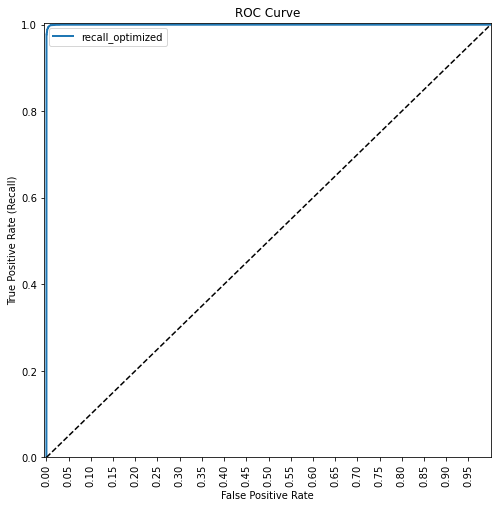

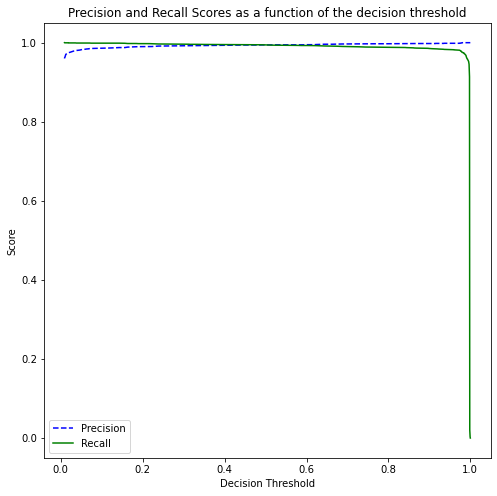

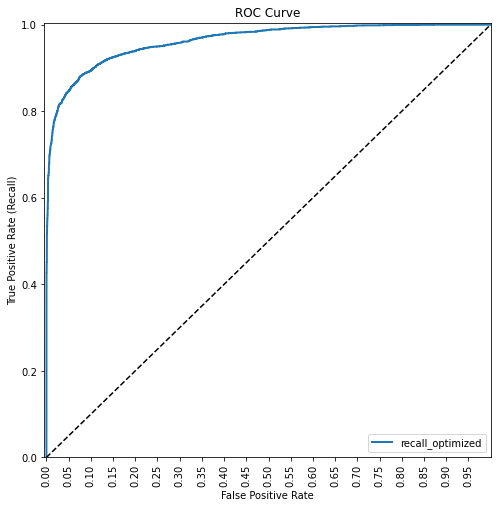

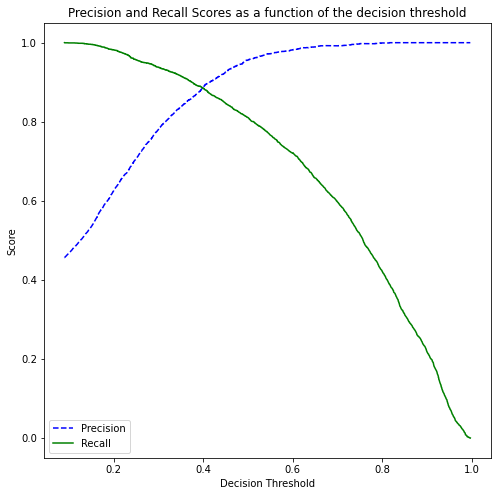

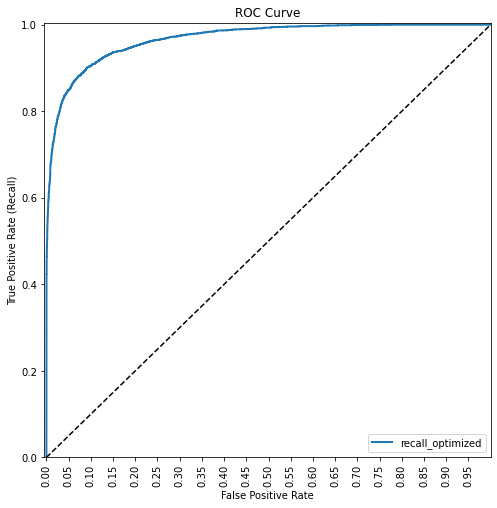

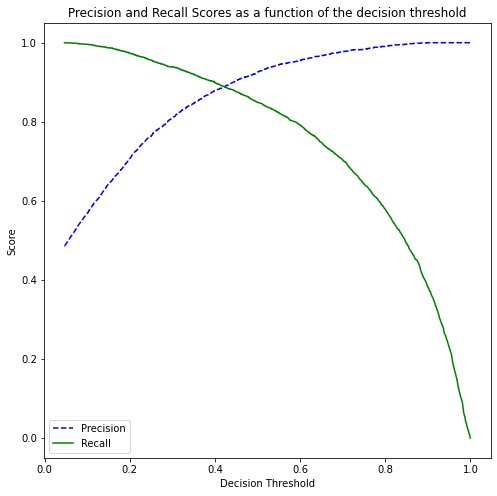

In [17]:
main (maxIterCount=0)
roc_for_clf (sclf_2_1)
roc_for_clf (catb_1)
roc_for_clf (lsvc_1)

In [22]:
def predict_threshold (clf, threshold_pr):
    
    test_file = "Data/test.csv"
    testDF = pd.read_csv (test_file)
    # testDF = testDF[:10]
    testDF['text'] = testDF.text.astype (str)
    testDF['keyword'] = testDF.keyword.astype (str)
    testDF['location'] = testDF.location.astype (str)
    submitDF = testDF[['id', 'target']]
    y_test_scores = clf.predict_proba (testDF)[:, 1]
    
    submitDF['target'] = adjusted_classes (y_test_scores, threshold_pr)
    submitDF['target'] = submitDF.target.astype (int)
    submitDF.to_csv ('submission_v'+str (VERSION) + clf.name + '.roc'+ str (threshold_pr) + '.csv', index=False)

In [27]:
predict_threshold (sclf_2_1, 0.9437731026789814) # 0.784, .787, .788, .787
# predict_threshold (catb_1, 0.5655311564417741)

Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)
Discrete2OneHot_FeatureTransformer: transform(): X.shape = (3263, 223)


# Additional

In [18]:
# clean file
def cleanDF ():
    
    import re
    text_cleaner_transformer = Text_cleaner_transformer ()
    files = ["Data/all.csv", "Data/train.csv", "Data/test.csv"]
    for file in files:
        
        df = pd.read_csv (file)
        df['text'] = text_cleaner_transformer.transform (df['text'])
        df.to_csv (file, index=False)
    return

In [19]:
def null_count ():
    
    global trainDF
    
    init ()
    # get total count of data including missing data
    total = trainDF.isnull ().sum ().sort_values (ascending=False)
    # print (total)

    # get percent of missing data relevant to all data
    percent = (trainDF.isnull ().sum ()/trainDF.isnull ().count ()).sort_values (ascending=False)
    # print (percent)
    
    missing_data = pd.concat ([total, percent], axis=1, keys=['total', 'percent'])
    return missing_data    

In [20]:
null_count ()

,total,percent
target,3263,0.283813
id,195,0.016961
text,0,0.000000
location,0,0.000000
keyword,0,0.000000
